# **3-Mass System PINN**

This repository demonstrates a Physics-Informed Neural Network (PINN) designed to solve an inverse problem for a 3-mass-spring system with a non-linear spring and **time-varying spring constants**. An inverse problem means we're trying to discover unknown parameters (here, spring constants and their switching time) by combining sparse observational data with the known physical laws of the system.
The PINN incorporates **hard constraints** by explicitly enforcing initial and boundary conditions during training:

**Initial Conditions** at ( $t = 0$ ) are enforced exactly:

$$
\begin{aligned}
x_1(0) = x_{10}, \quad x_2(0) = x_{20}, \quad x_3(0) = x_{30}
\end{aligned}
$$

$$
\begin{aligned}
\dot{x}_1(0) = v_{10}, \quad \dot{x}_2(0) = v_{20}, \quad \dot{x}_3(0) = v_{30}
\end{aligned}
$$

**Boundary / Intermediate / Final Conditions** (e.g., at time ( $t = T$ , $t = T/2$ )) may also be included as known constraints or observation points, and are enforced exactly within the network architecture or via augmented loss functions.


---

## ODE System for Nonlinear 3-Mass-Spring with Trainable Parameters

### System of Differential Equations

The system models three masses connected via nonlinear springs. The dynamics of the system are governed by second-order ODEs:

$$
\begin{aligned}
m_1 \frac{d^2 x_1}{dt^2} &= -k_1 x_1 - k_2 x_1^3 + k_2 x_2 \\
m_2 \frac{d^2 x_2}{dt^2} &= k_2 x_1 - k_2 x_2 - k_3 x_2 + k_3 x_3 \\
m_3 \frac{d^2 x_3}{dt^2} &= k_3 x_2 - k_3 x_3
\end{aligned}
$$

Where:

- displacements of masses  ( $m_1, m_2, m_3$): $x_1, x_2, x_3$ 
- spring constants:  $k_1, k_2, k_3$ 
- The spring between  $m_1$ and $m_2$ is **nonlinear**, using a cubic term $x_1^3$


---

### Dynamics

- **Nonlinear spring force**:  
  The second spring includes a cubic term $x_1^3$, introducing nonlinearity.

- **Step change (switching)** in the spring constants $k_1$ and $k_2$  
  at a trainable switching time $t_{\text{switch}}$.

- **Heaviside-like function**:  
  Used to smoothly transition spring parameters around the switching point using a steep $\tanh$ function.

---

### Spring Constant Switching

A **switching mechanism** is implemented at a trainable switching time $t_{\text{switch}}$ to model a change in material or system behavior:

- **Before the switch**:
  
$$
  k_1 = k_{1a}, \quad k_2 = k_{2a}
$$

- **After the switch**:
  
$$
  k_1 = k_{1b}, \quad k_2 = k_{2b}
$$

- **Constant**:
  
  Parameter $k_3$ remains fixed for all time.

---

### Smooth Switching via Tanh

To ensure differentiability for training with gradient-based methods, a smooth approximation of the step function is used:

$$
\text{weight\_after}(t) = \frac{1}{2} \left( \tanh\left(c \cdot (t - t_{\text{switch}})\right) + 1 \right)
$$

$$
\text{weight\_before}(t) = 1 - \text{weight\_after}(t)
$$

Where $c$ is a steepness coefficient.

The effective spring constants at time $t$ are computed as:

$$
\begin{aligned}
k_1(t) &= \text{weight\_before}(t) \cdot k_{1a} + \text{weight\_after}(t) \cdot k_{1b} \\
k_2(t) &= \text{weight\_before}(t) \cdot k_{2a} + \text{weight\_after}(t) \cdot k_{2b} \\
k_3(t) &= k_3 \quad \text{(constant)}
\end{aligned}
$$

---

### **Initial and Boundary Conditions**

To ensure a well-posed problem and to guide the training of the PINN, initial and possibly intermediate/final conditions are applied:

- **At initial time** $t = 0$:
  - Initial displacements:
    
$$
    x_1(0) = x_{10}, \quad x_2(0) = x_{20}, \quad x_3(0) = x_{30}
$$

  - Initial velocities:

$$  
    \dot{x}_1(0) = v_{10}, \quad \dot{x}_2(0) = v_{20}, \quad \dot{x}_3(0) = v_{30}
$$

- **At intermediate time**:  
  Observational data or known values may be available at specific intermediate points $t_i$, which can be used to constrain the solution or train the PINN more effectively.

- **At final time** $t = T$:  
  Displacement or velocity conditions at final time may be known or targeted in inverse problems:

  $x_j(T) = x_{jT}$ or $\dot{x}_j(T) = v_{jT}$, for $j = 1, 2, 3$

These conditions are integrated into the loss function of the PINN, helping guide the neural network to learn both the solution and the unknown physical parameters.


## Understanding the Loss Functions in This PINN
This Physics-Informed Neural Network (PINN) is trained by minimizing a combination of three distinct loss functions. Each loss term ensures that the neural network's solution (`x_i(t)`) adheres to different aspects of the problem: observed data, governing physical laws, and specific known conditions (like initial states or intermediate boundary values).

### Data Loss (`data_loss`)
- Purpose: This term measures how well the neural network's predicted solution matches the available observed data points.
- Calculation: It's typically calculated as the Mean Squared Error (MSE) between the PINN's output `x_pred` at the t_data points and the corresponding true `x_data` values.
- Role: It acts as a standard supervised learning loss, guiding the neural network to fit the discrete observations. Without data loss, the PINN might find a solution that satisfies the physics but doesn't align with any real-world measurements.
### Physics Loss (`physics_loss`)
- Purpose: This term enforces the governing physical laws (in this case, the Ordinary Differential Equations of the 3-mass system) throughout the entire time domain, not just at data points.
- Calculation: The core idea is to compute the "residual" of the differential equations. For each equation (e.g., for `m1 d2x1/dt2 - (-k1 x1 - k2 x1^3 + k2 x2) = 0`), the PINN predicts `x1, x2, x3` at a set of randomly sampled t_physics (collocation points). PyTorch's automatic differentiation (`torch.autograd.grad`) is then used to compute the necessary derivatives (first and second order, `dx/dt` and `d2x/dt2`) of the PINN's output with respect to time. These derivatives, along with the predicted positions, are plugged into the ODEs. The physics_loss is the Mean Squared Error of these residuals.
- Role: This is the "physics-informed" part. By driving the residuals to zero, the PINN learns a solution that inherently satisfies the differential equations. This helps the network generalize beyond sparse data points and provides robustness, especially when data is scarce or noisy. The non-linear spring term x1^3 is directly incorporated into these residual equations.
### Known Points Loss - **Initial/Boundary condition Loss** (`known_points_loss`)

- Purpose: This loss term explicitly enforces the initial conditions (at t=0) and any other known "**boundary**" conditions (i.e., exact positions and velocities at specific **intermediate** ( at `t=2` or final time points `t=5`). These are typically "**hard**" constraints that the solution must satisfy.
- Calculation: Similar to data loss, but applied strictly at t_known_points. It calculates the MSE between the PINN's predicted positions (`x_pred_known`) and velocities (`dx_dt_known`) at these specific times and their known true values (`x_known_true`, `v_known_true`). The velocities are also computed using automatic differentiation.
- Role: This loss acts as a strong "**anchor**" for the PINN's solution. It ensures that the learned trajectory starts from the correct initial state and passes precisely through any other predefined states. This is crucial for obtaining a unique and physically realistic solution, as differential equations require such conditions for well-posedness.

### **Adaptive Weighting**

Each of these loss terms can have very different magnitudes and gradient scales. If not balanced, one loss might overpower the others, preventing the overall model from converging effectively. This code uses an adaptive weighting strategy based on the gradient norms of the individual loss components:
It calculates the gradient norm of the data_loss, physics_loss, and known_points_loss with respect to the network parameters.
It then adjusts the lambda (weighting factor) for the physics_loss and known_points_loss dynamically, often scaling them by the ratio of the data_loss gradient norm to their own gradient norm. This aims to equalize the "pull" that each loss exerts on the network's parameters, promoting more balanced and stable training.
The lambda_known_points in particular is often allowed to be quite high (e.g., up to 1000.0) because these conditions are considered highly critical.

## **Break down the code section by section**
Now Let's in the following break down the code section by section:

## **1. Initial Setup and Imports**

```python
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

```

This section imports all necessary libraries:

`torch`, `torch.nn`, `torch.optim`, `torch.nn.functional`: Core PyTorch modules for building and training neural networks.
`numpy`: For numerical operations, especially for generating synthetic data.
`matplotlib.pyplot`: For plotting and visualization.
`scipy.integrate.solve_ivp`: Used to numerically solve the Ordinary Differential Equations (ODEs) to generate our "true" synthetic data.
`math`: For mathematical constants like pi. It also sets the computation device to GPU if available (for faster training) and enables high-precision matrix multiplications for compatible NVIDIA GPUs, which can boost performance.


## **2. Fourier Feature Encoding Helper Function**

```python
def fourier_encode(x, freqs):
    """
    Applies Fourier Feature Encoding to an input tensor.
    ...
    """
    # ... (function body) ...
```

This function is a crucial feature engineering step. Neural Networks, especially simple Multi-Layer Perceptrons (MLPs), can sometimes struggle to learn high-frequency (rapidly changing) patterns or sharp transitions.

What it does: It takes an input (x, which is time in our case) and transforms it into a much higher-dimensional space. For each original input feature, it generates sine and cosine waves at various frequencies (freqs).
Why it's useful for PINNs: The solutions to ODEs, especially non-linear ones or those with switching parameters, can be oscillatory or have sudden changes. Fourier features help the neural network "see" these high-frequency components more easily, allowing it to learn the underlying function more accurately and efficiently.


## **3. The PINN Model (`ThreeMassPINN Class`)**

```python
class ThreeMassPINN(nn.Module):
    def __init__(self, num_layers=4, units_per_layer=256, output_dim=3,
                 fourier_features=True, num_fourier_modes=20):
        super(ThreeMassPINN, self).__init__()

        # ... (initialization of layers and parameters) ...

    # Properties to get positive spring constants
    @property
    def k1a(self): return F.softplus(self.k1a_raw)
    # ... (other k properties) ...

    # Property to get the constrained switching time
    @property
    def t_switch(self):
        return self.min_t_switch + (self.max_t_switch - self.min_t_switch) * torch.sigmoid(self.t_switch_raw)

    def forward(self, t):
        # ... (forward pass logic, including Fourier encoding) ...

    def compute_physics_loss(self, t_physics):
        # ... (physics loss calculation) ...

    def compute_known_point_loss(self, t_known_points, x_known_true, v_known_true):
        # ... (known points loss calculation) ...
```

### Core of the PINN

This is the core of our PINN. It inherits from `nn.Module`, making it a standard PyTorch neural network.

---

### `__init__` (Constructor)

- **Defines the neural network architecture**:
  - An input layer, multiple hidden layers, and an output layer.
  - `units_per_layer` and `num_layers` control the network's complexity.

- **Initializes parameters related to Fourier features**:
  - `fourier_features` (boolean to enable/disable).
  - `num_fourier_modes` (number of frequencies to use).
  - The input layer's size adapts if Fourier features are enabled.

- **Initializes trainable parameters (`nn.Parameter`)**:
  - `k1a_raw`, `k1b_raw`, `k2a_raw`, `k2b_raw`, `k3_raw`: Raw spring constants.
  - `t_switch_raw`: Raw parameter for the time at which `k1` and `k2` change.

- **Initializes fixed parameters**:
  - `m1`, `m2`, `m3` (masses).

- **Properties (`@property`)**:
  - Allow accessing `k1a`, `k1b`, etc., as attributes.
  - Use `F.softplus(self.kX_raw)` to ensure positive spring constants.
  - Use `torch.sigmoid(self.t_switch_raw)` to constrain `t_switch` to a range (e.g., between 1.0s and 4.0s).

---

### `forward(self, t)`

- Defines how data flows through the network.
- Takes time `t` as input.
- If `fourier_features` is enabled:
  - `t` is transformed by the `fourier_encode` function.
- The (possibly encoded) `t_processed` is passed through:
  1. `input_layer`
  2. `hidden_layers` with `F.mish` activation (a smooth alternative to ReLU)
  3. `output_layer`
- **Output**: Predicted positions of the three masses: `[x1(t), x2(t), x3(t)]`

---

### `compute_physics_loss(self, t_physics)`

- Calculates the **physics loss**.
- `t_physics` is a batch of random collocation points.
- `t_physics.requires_grad_(True)` is set to enable autograd.

#### Steps:
1. Predict `x1`, `x2`, `x3` at `t_physics`.
2. Use `torch.autograd.grad` to compute:
   - First derivatives (velocities)
   - Second derivatives (accelerations)
3. **Effective Spring Constants**:
   - `k1_effective`, `k2_effective` are computed using `k1a`, `k1b`, `k2a`, `k2b`, and `t_switch`.
   - A `tanh` function creates a smooth transition (step function approximation).
4. **ODEs (Residuals)**:
   - Compare predicted accelerations to the right-hand side of the system's ODEs.
   - Include non-linear terms like `x1**3`.
   - Residuals: `r1`, `r2`, `r3`
5. **Loss**:
   - `physics_loss` is the Mean Squared Error (MSE) of these residuals.
   - Minimizing this trains the network to satisfy the ODEs.

---

### `compute_known_point_loss(self, t_known_points, x_known_true, v_known_true)`

- Calculates the **known points loss** (initial/boundary conditions).
- Inputs:
  - Specific `t_known_points` (e.g., 0.0, 2.0, 5.0)
  - True positions `x_known_true` and velocities `v_known_true`
- Steps:
  1. Predict positions using the PINN.
  2. Use `torch.autograd.grad` to compute predicted velocities.
  3. Compute MSE between:
     - Predicted and true positions
     - Predicted and true velocities

- This loss enforces that the solution starts at and passes through known physical states.


## **4. Synthetic Data Generation**

```python
def odes_system_step_nonlinear(t, y, k1_val, k2_val, k3_val, m1, m2, m3):
    # ... (ODE definition) ...

# True parameters for data generation
true_k1a = 5.0
# ... (other true parameters) ...

# ... (solve_ivp calls to generate data) ...
```


### `odes_system_step_nonlinear`

- This standard Python function defines the exact, "true" behavior of our 3-mass system.
- It serves as the **ground truth** that the PINN aims to learn.
- Key features:
  - Models a **step change** in `k1` and `k2` by segmenting the `solve_ivp` calls.
  - Includes a **non-linearity**: `x1**3`.

---

### `solve_ivp`

- `scipy.integrate.solve_ivp` is a robust numerical ODE solver.
- Used **twice**:
  1. For the time interval **before** the spring constant switch (`true_t_switch`).
  2. For the time interval **after**, with the corresponding `true_k` values.
- This generates:
  - `t_data`: Synthetic time values.
  - `x_data`: Corresponding positions.

---

### Known Points Extraction

- Specific `known_times_np` are selected from the numerical solution.
- Their corresponding true values:
  - `x_known_true_tensor` (positions)
  - `v_known_true_tensor` (velocities)
- These are used in the **`known_points_loss`** function to enforce initial/boundary conditions.



## **5. Training Loop**

```python
# PINN setup
pinn = ThreeMassPINN(...)
optimizer = optim.Adam(pinn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8000, eta_min=1e-6)

# Training parameters
epochs = 20000
N_physics_points = 500
lambda_data = 1.0
lambda_physics = 0.05
lambda_known_points = 1.0

# --- Adaptive Weighting Setup ---
history = { ... }

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # 1. Data Loss
    data_loss = ...

    # 2. Physics Loss
    physics_loss = ...

    # 3. Known Points Loss
    known_points_loss = ...

    # --- Adaptive Weighting Logic (Corrected Gradient-Norm Balancing) ---
    # ... (gradient norm calculations and adaptive lambda adjustments) ...

    # Combined Loss using the adaptive weight
    total_loss = lambda_data * data_loss + \
                 adaptive_lambda_physics * physics_loss + \
                 adaptive_lambda_known_points * known_points_loss

    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0) # Gradient clipping
    optimizer.step()
    scheduler.step() # Update learning rate

    # ... (history logging and printing) ...
```


### Training the PINN

This is where the magic happens – the **PINN learns!**

---

#### Model Instantiation

- An instance of `ThreeMassPINN` is created with **Fourier features enabled**.

---

#### Optimizer

- `optim.Adam` is used for its efficiency in training deep models.
- It updates:
  - Neural network weights
  - Trainable physical parameters (`k1a_raw`, `t_switch_raw`, etc.)

---

#### Learning Rate Scheduler

- `CosineAnnealingLR` gradually decreases the learning rate over `T_max` epochs.
- Helps improve convergence during the later stages of training.

---

#### Training Parameters

- **`epochs`**: Total number of training iterations.
- **`N_physics_points`**: Number of random points sampled per epoch to compute physics loss.
- **Loss weights**:
  - `lambda_data`
  - `lambda_physics`
  - `lambda_known_points`

---

#### **Adaptive Weighting Logic**

A key technique for PINNs:

- Calculates **gradient norms** separately for:
  - `data_loss`
  - `physics_loss`
  - `known_points_loss`
- Dynamically adjusts:
  - `adaptive_lambda_physics`
  - `adaptive_lambda_known_points`
- **Goal**: Scale the physics and known points losses so their gradients match the data loss gradient in magnitude.
- Prevents any one loss from dominating, ensuring **stable and balanced training**.
- `total_loss` is the sum of all three losses, each weighted by its (possibly adaptive) lambda.

---

#### Optimization Steps

1. `optimizer.zero_grad()`  
   → Clears existing gradients.

2. `total_loss.backward()`  
   → Computes gradients of `total_loss` with respect to all trainable parameters.

3. `torch.nn.utils.clip_grad_norm_`  
   → Applies **gradient clipping** to avoid exploding gradients (common in deep, nonlinear models).

4. `optimizer.step()`  
   → Updates network weights and physical parameters.

5. `scheduler.step()`  
   → Updates the learning rate according to the scheduler.

---

#### History and Logging

- Logs:
  - Individual loss components
  - Inferred physical parameters
- Provides periodic print statements to monitor **training progress** and **convergence**.


## 6. **Visualization**

```python
# ... (plotting loss history, inferred parameters, learning rates) ...
# Plot PINN predictions vs. true data
plt.figure(figsize=(12, 8))
# ... (plotting data points and PINN predictions) ...
# Plot the known points (initial/boundary conditions)
plt.plot(t_known_points.cpu().detach().numpy(), x_known_true_tensor.cpu().detach().numpy()[:, 0], 'rx', ...)
# ... (plotting inferred and true switch times) ...
plt.show()
```

### Visualization Overview

This section generates several plots to help visualize the **training process** and the **final results** of the PINN model:

- **Loss History**  
  Displays how `total_loss`, `data_loss`, `physics_loss`, and `known_points_loss` evolve over training epochs. This helps in diagnosing convergence and optimization stability.

- **Inferred Parameters**  
  Plots the learned values of `k1a`, `k1b`, `k2a`, `k2b`, `k3`, and `t_switch` across epochs, and compares them against their true values. This is critical for evaluating the accuracy of the inverse problem solution.

- **Learning Rate and Adaptive Lambdas**  
  Shows the dynamic changes in:
  - Learning rate (`lr`)
  - Adaptive loss weights (`adaptive_lambda_physics`, `adaptive_lambda_known_points`)  
  These plots reveal how training balances different loss components over time.

- **PINN Predictions vs. Synthetic Data**  
  The most important visualization:
  - Plots the predicted trajectories (`x1`, `x2`, `x3`) from the trained PINN.
  - Overlays the ground-truth synthetic data and known points (initial/boundary conditions).
  - Includes both **inferred** and **true** `t_switch` values.  
  This enables a direct visual assessment of how accurately the PINN has learned the system’s dynamics.



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math # Import math for pi

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# --- Fourier Feature Encoding ---
def fourier_encode(x, freqs):
    """
    Applies Fourier Feature Encoding to an input tensor.

    Args:
        x (torch.Tensor): Input tensor (e.g., time `t`). Shape: (N, 1) or (N, D).
        freqs (torch.Tensor): Frequencies for encoding. Shape: (num_modes,).

    Returns:
        torch.Tensor: Concatenated original input, sine, and cosine features.
                      Shape: (N, D + D * num_modes * 2)
    """
    # Reshape freqs for broadcasting: (1, 1, num_modes)
    # x shape: (N, D)
    # Resulting products shape: (N, D, num_modes)
    x_expanded = x.unsqueeze(-1) # (N, D, 1)
    freqs_expanded = freqs.unsqueeze(0).unsqueeze(0) # (1, 1, num_modes)

    # Compute products (N, D, num_modes)
    products = x_expanded * freqs_expanded

    # Apply sine and cosine
    sin_features = torch.sin(products) # (N, D, num_modes)
    cos_features = torch.cos(products) # (N, D, num_modes)

    # Flatten the last two dimensions to get (N, D * num_modes)
    sin_features = sin_features.view(x.shape[0], -1) # (N, D * num_modes)
    cos_features = cos_features.view(x.shape[0], -1) # (N, D * num_modes)

    # Concatenate original input, sine, and cosine features
    return torch.cat([x, sin_features, cos_features], dim=-1)


# --- 1. Define the 3-Mass System ODEs (conceptually, implemented in physics loss) ---
#    Introducing a hypothetical non-linearity: k2 term becomes k2 * x1**3 for x1
#    m1 d2x1/dt2 = -k1 x1 - k2 x1^3 + k2 x2
#    m2 d2x2/dt2 = k2 x1 - k2 x2 - k3 x2 + k3 x3
#    m3 d2x3/dt2 = k3 x2 - k3 x3

In [6]:
# --- PINN that outputs xi(t) ---
class ThreeMassPINN(nn.Module):
    def __init__(self, num_layers=4, units_per_layer=256, output_dim=3,
                 fourier_features=True, num_fourier_modes=20):
        super(ThreeMassPINN, self).__init__()

        self.fourier_features = fourier_features
        self.num_fourier_modes = num_fourier_modes

        input_dim_calc = 1 # Original input dimension (time)
        if self.fourier_features:
            # Each original input feature (1) is multiplied by 2 * num_fourier_modes (for sin/cos)
            input_dim_calc += 1 * self.num_fourier_modes * 2
            # Register frequencies for Fourier encoding
            self.register_buffer(
                "freqs", torch.exp(torch.linspace(0, math.pi, self.num_fourier_modes))
            )

        self.input_layer = nn.Linear(input_dim_calc, units_per_layer)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(units_per_layer, units_per_layer) for _ in range(num_layers - 1)
        ])
        self.output_layer = nn.Linear(units_per_layer, output_dim)

        # Trainable parameters for spring constants (before and after switch)
        # Better initialization for k_raw parameters, assuming they are in a reasonable range (e.g., 1 to 20)
        self.k1a_raw = nn.Parameter(torch.rand(1, device=device) * 5 + 5) # Initialized closer to expected values
        self.k1b_raw = nn.Parameter(torch.rand(1, device=device) * 5 + 5)
        self.k2a_raw = nn.Parameter(torch.rand(1, device=device) * 5 + 5)
        self.k2b_raw = nn.Parameter(torch.rand(1, device=device) * 5 + 5)
        self.k3_raw = nn.Parameter(torch.rand(1, device=device) * 5 + 5)

        # Trainable parameter for the switching time
        self.min_t_switch = 1.0
        self.max_t_switch = 4.0
        self.t_switch_raw = nn.Parameter(torch.tensor([0.5], device=device))

        # Fixed mass parameters
        self.m1 = torch.tensor(1.0, dtype=torch.float32, device=device)
        self.m2 = torch.tensor(1.0, dtype=torch.float32, device=device)
        self.m3 = torch.tensor(1.0, dtype=torch.float32, device=device)

    # Properties to get positive spring constants
    @property
    def k1a(self): return F.softplus(self.k1a_raw)
    @property
    def k1b(self): return F.softplus(self.k1b_raw)
    @property
    def k2a(self): return F.softplus(self.k2a_raw)
    @property
    def k2b(self): return F.softplus(self.k2b_raw)
    @property
    def k3(self): return F.softplus(self.k3_raw)

    # Property to get the constrained switching time
    @property
    def t_switch(self):
        return self.min_t_switch + (self.max_t_switch - self.min_t_switch) * torch.sigmoid(self.t_switch_raw)

    def forward(self, t):
        if t.dim() == 1:
            t = t.unsqueeze(-1) # Ensure t is (N, 1)

        # Apply Fourier Feature Encoding if enabled
        if self.fourier_features:
            t_processed = fourier_encode(t, self.freqs)
        else:
            t_processed = t

        x = F.mish(self.input_layer(t_processed))
        for layer in self.hidden_layers:
            x = F.mish(layer(x))
        return self.output_layer(x)

    # --- Computes residuals using autograd ---
    def compute_physics_loss(self, t_physics):
        t_physics.requires_grad_(True)

        x_pred = self(t_physics)
        x1 = x_pred[:, 0:1]
        x2 = x_pred[:, 1:2]
        x3 = x_pred[:, 2:3]

        # Compute first derivatives (velocities)
        dx1_dt = torch.autograd.grad(x1, t_physics, grad_outputs=torch.ones_like(x1), create_graph=True)[0]
        dx2_dt = torch.autograd.grad(x2, t_physics, grad_outputs=torch.ones_like(x2), create_graph=True)[0]
        dx3_dt = torch.autograd.grad(x3, t_physics, grad_outputs=torch.ones_like(x3), create_graph=True)[0]

        # Compute second derivatives (accelerations)
        d2x1_dt2 = torch.autograd.grad(dx1_dt, t_physics, grad_outputs=torch.ones_like(dx1_dt), create_graph=True)[0]
        d2x2_dt2 = torch.autograd.grad(dx2_dt, t_physics, grad_outputs=torch.ones_like(dx2_dt), create_graph=True)[0]
        d2x3_dt2 = torch.autograd.grad(dx3_dt, t_physics, grad_outputs=torch.ones_like(dx3_dt), create_graph=True)[0]

        # Use a very steep tanh to approximate the heaviside function for spring constant switching
        # Adjusted epsilon for better stability
        epsilon = 1e-3
        weight_before = 0.5 * (1.0 - torch.tanh((t_physics - self.t_switch) / epsilon))
        weight_after = 0.5 * (1.0 + torch.tanh((t_physics - self.t_switch) / epsilon))

        k1_effective = self.k1a * weight_before + self.k1b * weight_after
        k2_effective = self.k2a * weight_before + self.k2b * weight_after
        k3_effective = self.k3

        # --- MODIFIED ODEs with non-linear parameter involvement ---
        # m1 d2x1/dt2 = -k1 x1 - k2 x1^3 + k2 x2
        # m2 d2x2/dt2 = k2 x1 - k2 x2 - k3 x2 + k3 x3
        # m3 d2x3/dt2 = k3 x2 - k3 x3

        r1 = self.m1 * d2x1_dt2 - (-k1_effective * x1 - k2_effective * (x1**3) + k2_effective * x2) # NON-LINEAR TERM
        r2 = self.m2 * d2x2_dt2 - (k2_effective * x1 - k2_effective * x2 - k3_effective * x2 + k3_effective * x3)
        r3 = self.m3 * d2x3_dt2 - (k3_effective * x2 - k3_effective * x3)

        physics_loss = torch.mean(r1**2) + torch.mean(r2**2) + torch.mean(r3**2)
        return physics_loss

    # --- Method to compute loss at known points (initial/boundary conditions) ---
    def compute_known_point_loss(self, t_known_points, x_known_true, v_known_true):
        t_known_points.requires_grad_(True) # Ensure gradients can be computed

        x_pred_known = self(t_known_points)
        x1_pred_known = x_pred_known[:, 0:1]
        x2_pred_known = x_pred_known[:, 1:2]
        x3_pred_known = x_pred_known[:, 2:3]

        # Compute velocities at known points
        dx1_dt_known = torch.autograd.grad(x1_pred_known, t_known_points, grad_outputs=torch.ones_like(x1_pred_known), create_graph=True)[0]
        dx2_dt_known = torch.autograd.grad(x2_pred_known, t_known_points, grad_outputs=torch.ones_like(x2_pred_known), create_graph=True)[0]
        dx3_dt_known = torch.autograd.grad(x3_pred_known, t_known_points, grad_outputs=torch.ones_like(x3_pred_known), create_graph=True)[0]
        
        # Loss for positions at known points
        # Using [:, 0:1] to select the first column (x1), etc. for clarity and correctness
        loss_x_known = (torch.mean((x1_pred_known - x_known_true[:, 0:1])**2) +
                        torch.mean((x2_pred_known - x_known_true[:, 1:2])**2) +
                        torch.mean((x3_pred_known - x_known_true[:, 2:3])**2))
        
        # Loss for velocities at known points
        loss_v_known = (torch.mean((dx1_dt_known - v_known_true[:, 0:1])**2) +
                        torch.mean((dx2_dt_known - v_known_true[:, 1:2])**2) +
                        torch.mean((dx3_dt_known - v_known_true[:, 2:3])**2))

        return loss_x_known + loss_v_known


In [7]:
# --- Fit the PINN using both data and physics loss ---

# Generate some synthetic data with a step change AND non-linear k2 effect
def odes_system_step_nonlinear(t, y, k1_val, k2_val, k3_val, m1, m2, m3):
    x1, v1, x2, v2, x3, v3 = y
    # Modified ODE for d2x1_dt2 to match the non-linearity
    d2x1_dt2 = (1/m1) * (-k1_val * x1 - k2_val * (x1**3) + k2_val * x2)
    d2x2_dt2 = (1/m2) * (k2_val * x1 - k2_val * x2 - k3_val * x2 + k3_val * x3)
    d2x3_dt2 = (1/m3) * (k3_val * x2 - k3_val * x3)
    return [v1, d2x1_dt2, v2, d2x2_dt2, v3, d2x3_dt2]

# True parameters for data generation
true_k1a = 5.0
true_k1b = 15.0
true_k2a = 10.0 # This k2 will be multiplied by x1^3
true_k2b = 2.0
true_k3 = 7.0
true_t_switch = 2.5

masses = [1.0, 1.0, 1.0]

# Initial conditions (True values for data generation)
x1_0, v1_0 = 0.1, 0.0
x2_0, v2_0 = 0.0, 0.0
x3_0, v3_0 = 0.0, 0.0
initial_conditions = [x1_0, v1_0, x2_0, v2_0, x3_0, v3_0]

time_span = (0, 5) # seconds
t_data_np = np.linspace(time_span[0], time_span[1], 200) # More data points for complex dynamics

# Solve the ODEs in two segments for synthetic data
sol1 = solve_ivp(
    odes_system_step_nonlinear, # Use the new nonlinear ODE function
    (time_span[0], true_t_switch),
    initial_conditions,
    args=(true_k1a, true_k2a, true_k3, masses[0], masses[1], masses[2]),
    t_eval=t_data_np[t_data_np < true_t_switch].flatten(),
    method='RK45',
    rtol=1e-9, atol=1e-9, # Higher precision for solver
    dense_output=True # ADDED: Ensure dense output is enabled
)

final_y_sol1 = sol1.y[:, -1]

sol2 = solve_ivp(
    odes_system_step_nonlinear, # Use the new nonlinear ODE function
    (true_t_switch, time_span[1]),
    final_y_sol1,
    args=(true_k1b, true_k2b, true_k3, masses[0], masses[1], masses[2]),
    t_eval=t_data_np[t_data_np >= true_t_switch].flatten(),
    method='RK45',
    rtol=1e-9, atol=1e-9, # Higher precision for solver
    dense_output=True # ADDED: Ensure dense output is enabled
)

# Combine the results
t_data_combined = np.concatenate((sol1.t, sol2.t))
y_data_combined = np.concatenate((sol1.y.T, sol2.y.T)) # y contains [x1, v1, x2, v2, x3, v3]

# Sort the data by time
sort_indices = np.argsort(t_data_combined)
t_data_combined = t_data_combined[sort_indices]
y_data_combined = y_data_combined[sort_indices]

# Extract x_data and v_data from combined y_data
x_data_np = y_data_combined[:, [0, 2, 4]] # Positions
v_data_np = y_data_combined[:, [1, 3, 5]] # Velocities


# Convert generated data to PyTorch tensors and move to device
t_data = torch.tensor(t_data_combined, dtype=torch.float32, device=device).unsqueeze(-1)
x_data = torch.tensor(x_data_np, dtype=torch.float32, device=device)

print(f"Generated data shape: t_data={t_data.shape}, x_data={x_data.shape}")

# --- Define Known Points (Initial/Boundary Conditions) ---
# We will enforce conditions at t=0, t=2.0, and t=5.0
# t=0 is the initial condition
# t=2.0 is an intermediate "boundary" condition
# t=5.0 is a final "boundary" condition

known_times_np = np.array([0.0, 2.0, 5.0])
# Interpolate true positions and velocities at these known times from scipy solution
# Ensure sol1.sol and sol2.sol are callable by dense_output=True in solve_ivp
known_states_at_times = []
for t_val in known_times_np:
    # Use sol1.sol for times before or at the switch, sol2.sol for times after
    # Note: for t_val == true_t_switch, both sol1.sol and sol2.sol would work
    # if the solution is continuous across the switch point.
    if t_val <= true_t_switch: # Use <= to ensure switch point is covered by sol1 if it's the exact end of sol1's range
        known_states_at_times.append(sol1.sol(t_val))
    else:
        known_states_at_times.append(sol2.sol(t_val))
known_states_at_times = np.array(known_states_at_times).T # Transpose to get (6, num_known_points)

t_known_points = torch.tensor(known_times_np, dtype=torch.float32, device=device).unsqueeze(-1)
x_known_true_tensor = torch.tensor(known_states_at_times[[0,2,4], :].T, dtype=torch.float32, device=device) # Positions
v_known_true_tensor = torch.tensor(known_states_at_times[[1,3,5], :].T, dtype=torch.float32, device=device) # Velocities


# PINN setup
pinn = ThreeMassPINN(units_per_layer=256, fourier_features=True, num_fourier_modes=20).to(device)
optimizer = optim.Adam(pinn.parameters(), lr=1e-3)

# Learning Rate Scheduler (Cosine Annealing)
# Corrected: lr_scheduler is a direct attribute of optim, not optim.optim
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8000, eta_min=1e-6)



Generated data shape: t_data=torch.Size([200, 1]), x_data=torch.Size([200, 3])


In [8]:
# Training parameters
epochs = 20000
N_physics_points = 500 # Increased physics points for better resolution
lambda_data = 1.0
lambda_physics = 0.05 # Initial weight, will be adaptively adjusted
lambda_known_points = 1.0 # Initial weight for known conditions (will be adaptively adjusted)

# --- Adaptive Weighting Setup ---
history = {
    'loss': [], 'data_loss': [], 'physics_loss': [], 'scaled_physics_loss': [],
    'known_points_loss': [], 'scaled_known_points_loss': [], # Added scaled_known_points_loss
    'k1a': [], 'k1b': [], 'k2a': [], 'k2b': [], 'k3': [], 't_switch': [],
    'current_lr': [], 'adaptive_lambda_physics': [], 'adaptive_lambda_known_points': [] # Added adaptive_lambda_known_points
}

Epoch 0/20000, LR: 1.00e-03, Loss: 0.495056, Data Loss: 0.296565, Physics Loss (Raw): 6.520285, Scaled Physics Loss: 0.006520, Known Points Loss (Raw): 1.766981, Scaled Known Points Loss: 0.191971
  Adaptive Lambda Physics: 0.0010, Adaptive Lambda Known Points: 0.1086
  k1a: 8.3753 (True: 5.0), k1b: 6.1539 (True: 15.0)
  k2a: 9.8354 (True: 10.0), k2b: 6.4031 (True: 2.0)
  k3: 8.1518 (True: 7.0), t_switch: 2.8667 (True: 2.5)
Epoch 200/20000, LR: 9.98e-04, Loss: 0.012850, Data Loss: 0.003482, Physics Loss (Raw): 8.948701, Scaled Physics Loss: 0.008949, Known Points Loss (Raw): 0.002097, Scaled Known Points Loss: 0.000419
  Adaptive Lambda Physics: 0.0010, Adaptive Lambda Known Points: 0.1998
  k1a: 8.4117 (True: 5.0), k1b: 6.3760 (True: 15.0)
  k2a: 9.7634 (True: 10.0), k2b: 6.2123 (True: 2.0)
  k3: 8.3019 (True: 7.0), t_switch: 2.7922 (True: 2.5)
Epoch 400/20000, LR: 9.94e-04, Loss: 0.011890, Data Loss: 0.002614, Physics Loss (Raw): 8.835401, Scaled Physics Loss: 0.008835, Known Points 

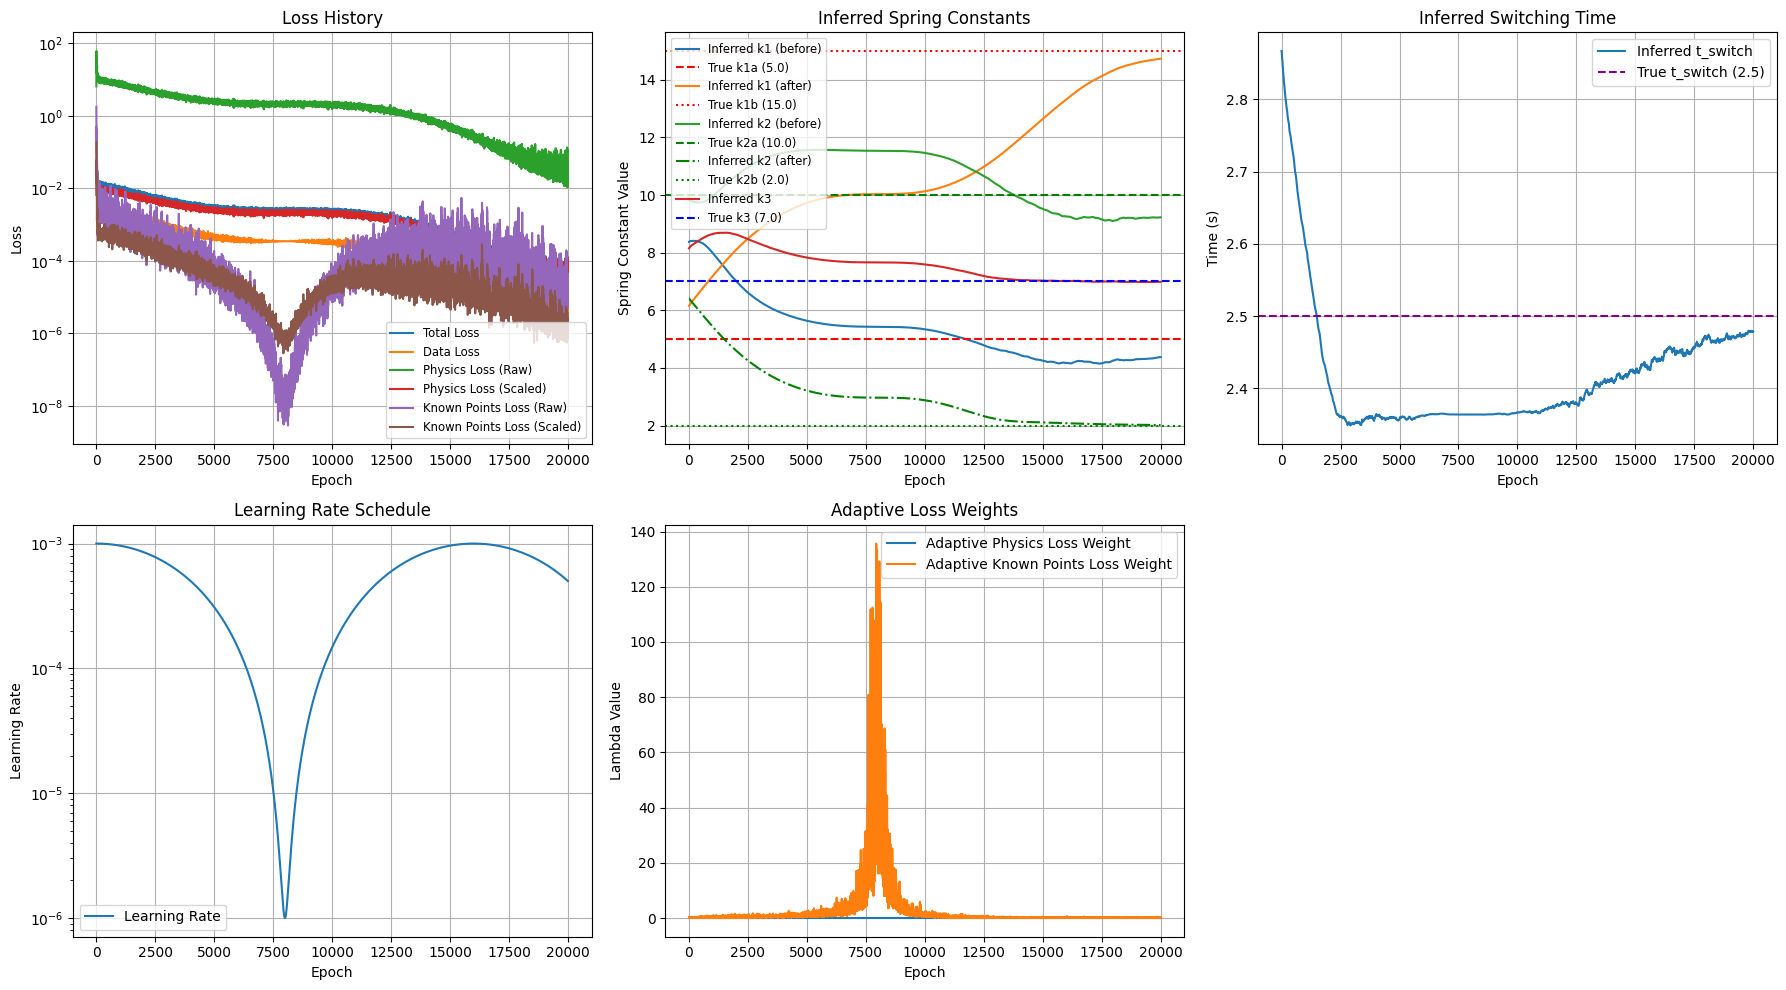

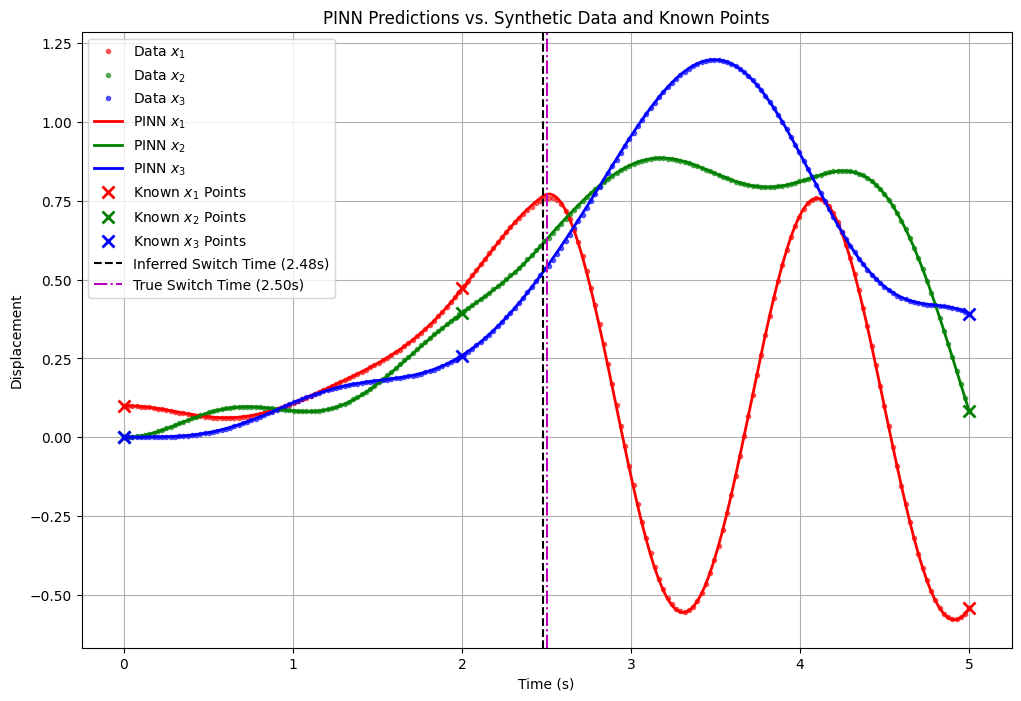

In [9]:
# Training loop
for epoch in range(epochs):
    optimizer.zero_grad() # Zero gradients once at the beginning of the iteration

    # 1. Data Loss
    x_pred_data = pinn(t_data)
    data_loss = torch.mean((x_pred_data - x_data)**2)

    # 2. Physics Loss
    t_physics_batch = torch.rand(N_physics_points, 1, device=device) * (time_span[1] - time_span[0]) + time_span[0]
    physics_loss = pinn.compute_physics_loss(t_physics_batch)

    # 3. Known Points Loss (New: handles initial and multiple boundary conditions)
    known_points_loss = pinn.compute_known_point_loss(
        t_known_points, x_known_true_tensor, v_known_true_tensor
    )

    # --- Adaptive Weighting Logic (Corrected Gradient-Norm Balancing) ---
    # Compute gradients of individual loss terms without zeroing the optimizer's state
    # This captures the raw gradient magnitudes from each loss.
    
    # Get gradients of data_loss w.r.t NN parameters (excluding trainable physics params if desired, but here we take all)
    # Use retain_graph=True for all intermediate grad calls
    data_grads_for_norm = torch.autograd.grad(
        data_loss,
        pinn.parameters(),
        retain_graph=True,
        allow_unused=True # Allow for parameters not touched by this loss
    )
    # Filter out None gradients and calculate norm
    data_grad_norm = torch.sqrt(sum([g.norm()**2 for g in data_grads_for_norm if g is not None]))
    # Handle case where no gradients are present for some reason (though unlikely for NN params)
    if data_grad_norm == 0: data_grad_norm = torch.tensor(1.0, device=device)


    # Get gradients of physics_loss w.r.t. ALL trainable parameters
    physics_grads_for_norm = torch.autograd.grad(
        physics_loss,
        pinn.parameters(),
        retain_graph=True,
        allow_unused=True # Allow for parameters not touched by this loss
    )
    # Filter out None gradients and calculate norm
    physics_grad_norm = torch.sqrt(sum([g.norm()**2 for g in physics_grads_for_norm if g is not None]))
    # Handle case where no gradients are present for some reason
    if physics_grad_norm == 0: physics_grad_norm = torch.tensor(1.0, device=device)

    # Get gradients of known_points_loss w.r.t. ALL trainable parameters
    known_points_grads_for_norm = torch.autograd.grad(
        known_points_loss,
        pinn.parameters(),
        retain_graph=True,
        allow_unused=True # Allow for parameters not touched by this loss
    )
    # Filter out None gradients and calculate norm
    known_points_grad_norm = torch.sqrt(sum([g.norm()**2 for g in known_points_grads_for_norm if g is not None]))
    # Handle case where no gradients are present for some reason
    if known_points_grad_norm == 0: known_points_grad_norm = torch.tensor(1.0, device=device)


    # Adjust lambda_physics based on gradient magnitudes
    adaptive_lambda_physics = lambda_physics * (data_grad_norm / physics_grad_norm).detach()
    # Clamp the adaptive lambda to prevent it from exploding or vanishing too much
    adaptive_lambda_physics = torch.clamp(adaptive_lambda_physics, 0.001, 10.0) # Example bounds

    # Adjust lambda_known_points based on gradient magnitudes
    adaptive_lambda_known_points = lambda_known_points * (data_grad_norm / known_points_grad_norm).detach()
    adaptive_lambda_known_points = torch.clamp(adaptive_lambda_known_points, 0.001, 1000.0) # Can be higher due to strictness of ICs


    # Combined Loss using the adaptive weight
    total_loss = lambda_data * data_loss + \
                 adaptive_lambda_physics * physics_loss + \
                 adaptive_lambda_known_points * known_points_loss

    # Now backpropagate the combined loss for final parameter updates
    total_loss.backward()
    
    # Clip gradients to prevent explosion (common cause of NaNs)
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0) # Clip gradients to a max norm of 1.0

    optimizer.step()
    scheduler.step() # Update learning rate

    history['loss'].append(total_loss.item())
    history['data_loss'].append(data_loss.item())
    history['physics_loss'].append(physics_loss.item())
    history['scaled_physics_loss'].append(adaptive_lambda_physics.item() * physics_loss.item()) # Store scaled value
    history['known_points_loss'].append(known_points_loss.item()) # Store raw known points loss
    history['scaled_known_points_loss'].append(adaptive_lambda_known_points.item() * known_points_loss.item()) # Store scaled known points loss
    history['k1a'].append(pinn.k1a.item())
    history['k1b'].append(pinn.k1b.item())
    history['k2a'].append(pinn.k2a.item())
    history['k2b'].append(pinn.k2b.item())
    history['k3'].append(pinn.k3.item())
    history['t_switch'].append(pinn.t_switch.item())
    history['current_lr'].append(optimizer.param_groups[0]['lr'])
    history['adaptive_lambda_physics'].append(adaptive_lambda_physics.item())
    history['adaptive_lambda_known_points'].append(adaptive_lambda_known_points.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}/{epochs}, LR: {optimizer.param_groups[0]['lr']:.2e}, "
              f"Loss: {total_loss.item():.6f}, Data Loss: {data_loss.item():.6f}, "
              f"Physics Loss (Raw): {physics_loss.item():.6f}, Scaled Physics Loss: {adaptive_lambda_physics.item() * physics_loss.item():.6f}, "
              f"Known Points Loss (Raw): {known_points_loss.item():.6f}, Scaled Known Points Loss: {adaptive_lambda_known_points.item() * known_points_loss.item():.6f}")
        print(f"  Adaptive Lambda Physics: {adaptive_lambda_physics.item():.4f}, Adaptive Lambda Known Points: {adaptive_lambda_known_points.item():.4f}")
        print(f"  k1a: {pinn.k1a.item():.4f} (True: {true_k1a}), k1b: {pinn.k1b.item():.4f} (True: {true_k1b})")
        print(f"  k2a: {pinn.k2a.item():.4f} (True: {true_k2a}), k2b: {pinn.k2b.item():.4f} (True: {true_k2b})")
        print(f"  k3: {pinn.k3.item():.4f} (True: {true_k3}), t_switch: {pinn.t_switch.item():.4f} (True: {true_t_switch})")

print("\n--- Training Complete ---")
print(f"Inferred k1 (before): {pinn.k1a.item():.4f} (True: {true_k1a})")
print(f"Inferred k1 (after): {pinn.k1b.item():.4f} (True: {true_k1b})")
print(f"Inferred k2 (before): {pinn.k2a.item():.4f} (True: {true_k2a})")
print(f"Inferred k2 (after): {pinn.k2b.item():.4f} (True: {true_k2b})")
print(f"Inferred k3: {pinn.k3.item():.4f} (True: {true_k3})")
print(f"Inferred t_switch: {pinn.t_switch.item():.4f} (True: {true_t_switch})")

# --- Visualization ---
plt.figure(figsize=(18, 10))

# Plot Loss History
plt.subplot(2, 3, 1)
plt.plot(history['loss'], label='Total Loss')
plt.plot(history['data_loss'], label='Data Loss')
plt.plot(history['physics_loss'], label='Physics Loss (Raw)')
plt.plot(history['scaled_physics_loss'], label='Physics Loss (Scaled)')
plt.plot(history['known_points_loss'], label='Known Points Loss (Raw)') # Plot raw known points loss
plt.plot(history['scaled_known_points_loss'], label='Known Points Loss (Scaled)') # Plot scaled known points loss
plt.yscale('log')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(fontsize='small')
plt.grid(True)

# Plot Inferred Spring Constants
plt.subplot(2, 3, 2)
plt.plot(history['k1a'], label='Inferred k1 (before)')
plt.axhline(y=true_k1a, color='r', linestyle='--', label=f'True k1a ({true_k1a})')
plt.plot(history['k1b'], label='Inferred k1 (after)')
plt.axhline(y=true_k1b, color='r', linestyle=':', label=f'True k1b ({true_k1b})')

plt.plot(history['k2a'], label='Inferred k2 (before)')
plt.axhline(y=true_k2a, color='g', linestyle='--', label=f'True k2a ({true_k2a})')
plt.plot(history['k2b'], color='g', linestyle='-.', label='Inferred k2 (after)') # Changed style for better visibility
plt.axhline(y=true_k2b, color='g', linestyle=':', label=f'True k2b ({true_k2b})')

plt.plot(history['k3'], label='Inferred k3')
plt.axhline(y=true_k3, color='b', linestyle='--', label=f'True k3 ({true_k3})')

plt.title('Inferred Spring Constants')
plt.xlabel('Epoch')
plt.ylabel('Spring Constant Value')
plt.legend(fontsize='small')
plt.grid(True)

# Plot Inferred Switching Time
plt.subplot(2, 3, 3)
plt.plot(history['t_switch'], label='Inferred t_switch')
plt.axhline(y=true_t_switch, color='purple', linestyle='--', label=f'True t_switch ({true_t_switch})')
plt.title('Inferred Switching Time')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(2, 3, 4)
plt.plot(history['current_lr'], label='Learning Rate')
plt.yscale('log')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

# Plot Adaptive Lambda Physics
plt.subplot(2, 3, 5)
plt.plot(history['adaptive_lambda_physics'], label='Adaptive Physics Loss Weight')
plt.plot(history['adaptive_lambda_known_points'], label='Adaptive Known Points Loss Weight') # Plot new adaptive lambda
plt.title('Adaptive Loss Weights')
plt.xlabel('Epoch')
plt.ylabel('Lambda Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot PINN predictions vs. true data
t_plot_np = np.linspace(time_span[0], time_span[1], 500).reshape(-1, 1)
t_plot_torch = torch.tensor(t_plot_np, dtype=torch.float32, device=device)
x_pred_plot_torch = pinn(t_plot_torch).detach().cpu().numpy()

plt.figure(figsize=(12, 8))
plt.plot(t_data.cpu().numpy(), x_data.cpu().numpy()[:, 0], 'r.', alpha=0.6, label='Data $x_1$')
plt.plot(t_data.cpu().numpy(), x_data.cpu().numpy()[:, 1], 'g.', alpha=0.6, label='Data $x_2$')
plt.plot(t_data.cpu().numpy(), x_data.cpu().numpy()[:, 2], 'b.', alpha=0.6, label='Data $x_3$')

plt.plot(t_plot_np, x_pred_plot_torch[:, 0], 'r-', linewidth=2, label='PINN $x_1$')
plt.plot(t_plot_np, x_pred_plot_torch[:, 1], 'g-', linewidth=2, label='PINN $x_2$')
plt.plot(t_plot_np, x_pred_plot_torch[:, 2], 'b-', linewidth=2, label='PINN $x_3$')

# Plot the known points (initial/boundary conditions)
# Detach both t_known_points and x_known_true_tensor before converting to numpy
plt.plot(t_known_points.cpu().detach().numpy(), x_known_true_tensor.cpu().detach().numpy()[:, 0], 'rx', markersize=8, mew=2, label='Known $x_1$ Points')
plt.plot(t_known_points.cpu().detach().numpy(), x_known_true_tensor.cpu().detach().numpy()[:, 1], 'gx', markersize=8, mew=2, label='Known $x_2$ Points')
plt.plot(t_known_points.cpu().detach().numpy(), x_known_true_tensor.cpu().detach().numpy()[:, 2], 'bx', markersize=8, mew=2, label='Known $x_3$ Points')

inferred_t_switch = pinn.t_switch.item()
plt.axvline(x=inferred_t_switch, color='k', linestyle='--', label=f'Inferred Switch Time ({inferred_t_switch:.2f}s)')
plt.axvline(x=true_t_switch, color='m', linestyle='-.', label=f'True Switch Time ({true_t_switch:.2f}s)')

plt.title('PINN Predictions vs. Synthetic Data and Known Points')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()
